# Table of contents

[1. Introduction](#Introduction)

[2. Obtaining the data](#Obtaining-the-data)

[3. Scrubbing the data](#Scrubbing-the-data)

[4. Exploring the data](#Exploring-the-data)

[5. Grid Search](#Grid-search)

# Introduction

The goal of this file is to find the best parameters for 0 level models for stacking.

***
# Obtaining the data

In this section, the data and the required libraries will be imported.

In [86]:
# Importing the required libraries
import pandas as pd
pd.set_option('display.max_columns', 50) # Display up to 50 columns at a time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm
plt.style.use('seaborn')
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12,5
import glob # To read all csv files in the directory
import seaborn as sns
import calendar
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, precision_recall_fscore_support
import itertools
import time
import xgboost as xgb

The most recent Kickstarter data from https://webrobots.io/kickstarter-datasets/ (from 14 March 2019) is stored in 56 separate csv files. The code below creates a list of all csv files beginning with 'Kickstarter' and concatenates them into one dataframe:

In [2]:
df = pd.concat([pd.read_csv(f) for f in glob.glob('data/Kickstarter*.csv')], ignore_index = True)

In [3]:
df.head(3)

backers_count                                              blurb  \
0            315                                      Babalus Shoes   
1             47  A colorful Dia de los Muertos themed oracle de...   
2            271  Electra's long awaited, eclectic Debut Pop/Roc...   

                                            category  \
0  {"id":266,"name":"Footwear","slug":"fashion/fo...   
1  {"id":273,"name":"Playing Cards","slug":"games...   
2  {"id":43,"name":"Rock","slug":"music/rock","po...   

   converted_pledged_amount country  created_at  \
0                     28645      US  1541459205   
1                      1950      US  1501684093   
2                     22404      US  1348987533   

                                             creator currency currency_symbol  \
0  {"id":2094277840,"name":"Lucy Conroy","slug":"...      USD               $   
1  {"id":723886115,"name":"Lisa Vollrath","slug":...      USD               $   
2  {"id":323849677,"name":"Electra","is_registere...      USD               $   

   currency_trailing_code current_currency    deadline  disable_communication  \
0                    True              USD  1552539775                  False   
1                    True              USD  1504976459                  False   
2                    True              USD  1371013395                  False   

  friends  fx_rate     goal          id is_backing  is_starrable is_starred  \
0     NaN      1.0  28000.0  2108505034        NaN         False        NaN   
1     NaN      1.0   1000.0   928751314        NaN         False        NaN   
2     NaN      1.0  15000.0   928014092        NaN         False        NaN   

   launched_at                                           location  \
0   1548223375  {"id":2462429,"name":"Novato","slug":"novato-c...   
1   1502384459  {"id":2400549,"name":"Euless","slug":"euless-t...   
2   1368421395  {"id":2423474,"name":"Hollywood","slug":"holly...   

                                                name permissions  \
0                           Babalus Children's Shoes         NaN   
1                            The Ofrenda Oracle Deck         NaN   
2  Record Electra's Debut Album (Pop, Rock, Class...         NaN   

                                               photo  pledged  \
0  {"key":"assets/023/667/205/a565fde5382d6b53276...  28645.0   
1  {"key":"assets/017/766/989/dd9f18c773a8546d996...   1950.0   
2  {"key":"assets/011/433/681/489fd66f7861fefd8c8...  22404.0   

                                             profile  \
0  {"id":3508024,"project_id":3508024,"state":"in...   
1  {"id":3094785,"project_id":3094785,"state":"ac...   
2  {"id":359847,"project_id":359847,"state":"inac...   

                                             slug  \
0                         babalus-childrens-shoes   
1                         the-ofrenda-oracle-deck   
2  record-electras-debut-album-pop-rock-classical   

                                          source_url  spotlight  staff_pick  \
0  https://www.kickstarter.com/discover/categorie...      False       False   
1  https://www.kickstarter.com/discover/categorie...       True       False   
2  https://www.kickstarter.com/discover/categorie...       True       False   

        state  state_changed_at  static_usd_rate  \
0        live        1548223375              1.0   
1  successful        1504976459              1.0   
2  successful        1371013395              1.0   

                                                urls  usd_pledged  \
0  {"web":{"project":"https://www.kickstarter.com...      28645.0   
1  {"web":{"project":"https://www.kickstarter.com...       1950.0   
2  {"web":{"project":"https://www.kickstarter.com...      22404.0   

        usd_type  
0  international  
1       domestic  
2  international

The resulting dataframe contains 209,222 projects.

In [4]:
len(df)

209222

***
# Scrubbing the data

In this section the data will be cleaned and pre-processed in order to allow for exploratory data analysis and modeling.

**Inspecting and dropping columns**

In [5]:
# Checking for duplicates of individual projects
print(f"Of the {len(df)} projects in the dataset, there are {len(df[df.duplicated(subset='id')])} which are listed more than once.")

Of the 209222 projects in the dataset, there are 26958 which are listed more than once.


Duplicates are an issue in this dataset and will need to be dealt with. Further cleaning of the data will help clarify which duplicates, if any, need to be removed.

Some columns contain very few nun-null entries, and can be dropped:

In [7]:
# Dropping columns that are mostly null
df.drop(['friends', 'is_backing', 'is_starred', 'permissions'], axis=1, inplace=True)

In [8]:
# Dropping columns that aren't useful
df.drop(['converted_pledged_amount', 'creator', 'currency', 'currency_symbol', 'currency_trailing_code', 'current_currency', 'fx_rate', 'photo', 'pledged', 'profile', 'slug', 'source_url', 'spotlight', 'state_changed_at', 'urls', 'usd_type'], axis=1, inplace=True)

**Converting datetime columns**

Columns containing dates are currently stored in unix time, and need to be converted to datetime. Because they have been converted from unix, all times are in UTC/GMT.

In [9]:
# Converting dates from unix to datetime
cols_to_convert = ['created_at', 'deadline', 'launched_at']
for c in cols_to_convert:
    df[c] = pd.to_datetime(df[c], origin='unix', unit='s')

In [10]:
print(f"The dataset contains projects added to Kickstarter between {min(df.created_at).strftime('%d %B %Y')} and {max(df.created_at).strftime('%d %B %Y')}.")

The dataset contains projects added to Kickstarter between 22 April 2009 and 14 March 2019.


Individual columns will now be pre-processed, and additional features engineered, where necessary.

**Blurb**

Natural language processing is beyond the scope of this project. The length of the blurbs written by project creators will be calculated though, in case this is useful for the model (e.g. people preferring to read shorter or longer blurbs when choosing what to fund). The original blurb variable will then be dropped.

In [11]:
# Count length of each blurb
df['blurb_length'] = df['blurb'].str.split().str.len()

# Drop blurb variable
df.drop('blurb', axis=1, inplace=True)

**Category**

The category variable is currently stored as a string, although it was clearly originally a dictionary. The example below shows that each project has both a category (e.g. games) and a sub-category (e.g. tabletop games). Both will be extracted.

In [12]:
# Example category value
df.iloc[0]['category']

'{"id":266,"name":"Footwear","slug":"fashion/footwear","position":5,"parent_id":9,"color":16752598,"urls":{"web":{"discover":"http://www.kickstarter.com/discover/categories/fashion/footwear"}}}'

In [13]:
# Extracting the relevant sub-category section from the string
f = lambda x: x['category'].split('/')[1].split('","position')[0]
df['sub_category'] = df.apply(f, axis=1)
print(df['category'])

0         {"id":266,"name":"Footwear","slug":"fashion/fo...
1         {"id":273,"name":"Playing Cards","slug":"games...
2         {"id":43,"name":"Rock","slug":"music/rock","po...
3         {"id":273,"name":"Playing Cards","slug":"games...
4         {"id":48,"name":"Nonfiction","slug":"publishin...
                                ...                        
209217    {"id":34,"name":"Tabletop Games","slug":"games...
209218    {"id":38,"name":"Electronic Music","slug":"mus...
209219    {"id":52,"name":"Hardware","slug":"technology/...
209220    {"id":295,"name":"Festivals","slug":"film & vi...
209221    {"id":13,"name":"Journalism","slug":"journalis...
Name: category, Length: 209222, dtype: object


In [14]:
# Extracting the relevant category section from the string, and replacing the original category variable
f = lambda x: x['category'].split('"slug":"')[1].split('","position"')[0].split('/')[0]
df['category'] = df.apply(f, axis=1)
print(df['category'])

0              fashion
1                games
2                music
3                games
4           publishing
              ...     
209217           games
209218           music
209219      technology
209220    film & video
209221      journalism
Name: category, Length: 209222, dtype: object


In [15]:
# Counting the number of unique categories
print(f"There are {df.category.nunique()} unique categories and {df.sub_category.nunique()} unique sub-categories.")

There are 15 unique categories and 145 unique sub-categories.


**Disable_communication**

99.7% of project owners did not disable communication with their backers (unsurprisingly). Because nearly all projects have the same value for this variable, it will be dropped as it does not provide much information.

In [16]:
# Checking the proportions of each category
df.disable_communication.value_counts(normalize=True)

False    0.997022
True     0.002978
Name: disable_communication, dtype: float64

In [17]:
df.drop('disable_communication', axis=1, inplace=True)

**Goal**

The goal amount of funding for each project is currently recorded in native currencies. In order to allow for fair comparisons between projects, goals will be converted into dollars (as amount pledged already is).

In [18]:
# Calculate new column 'usd_goal' as goal * static_usd_rate
df['usd_goal'] = round(df['goal'] * df['static_usd_rate'],2)

In [19]:
# Dropping goal and static_usd_rate
df.drop(['goal', 'static_usd_rate'], axis=1, inplace=True)

**Is_starrable**

Only 3.3% of projects were starrable by users. Although this is only a very small proportion, whether or not a project was liked and saved by users is likely to be informative about whether or not a project was successful, so the variable will be kept for now and assessed again once irrelevant rows have been dropped, to check it is still useful.

In [20]:
# Figure out what this is, and do a count_values() to figure out whether it's worth including or mostly FALSE
df.is_starrable.value_counts(normalize=True)

False    0.967403
True     0.032597
Name: is_starrable, dtype: float64

**Location**

The location field contains the town/city that a project originates from, as well as the country. There are a large number (15,235) of unique locations. Because the country is already recorded separately in the country field, and there are such a large number of unique categories (making one-hot encoding not useful, particularly as there are likely to be a lot of smaller towns and cities with very few projects), the column will be dropped.

In [21]:
# Example location value
df.iloc[0]['location']

'{"id":2462429,"name":"Novato","slug":"novato-ca","short_name":"Novato, CA","displayable_name":"Novato, CA","localized_name":"Novato","country":"US","state":"CA","type":"Town","is_root":false,"urls":{"web":{"discover":"https://www.kickstarter.com/discover/places/novato-ca","location":"https://www.kickstarter.com/locations/novato-ca"},"api":{"nearby_projects":"https://api.kickstarter.com/v1/discover?signature=1552595066.49b64db66a5124f5831752d055cd09aff20cc652&woe_id=2462429"}}}'

In [22]:
# Counting the number of unique locations
df.location.nunique()

15235

In [23]:
# Dropping location
df.drop('location', axis=1, inplace=True)

**Name**

The length of project names will be calculated, in case this is useful for the model. The original name variable will then be dropped.

In [24]:
# Count length of each name
df['name_length'] = df['name'].str.split().str.len()
# Drop name variable
df.drop('name', axis=1, inplace=True)

**Usd_pledged**

This column requires rounding to two decimal places.

In [25]:
df['usd_pledged'] = round(df['usd_pledged'],2)

**Additional calculated features**

Additional features can be calculated from the existing features, which may also help to predict whether a project is successfully funded. The features to be added are: time from creation to launch, campaign length, launch day of week, deadline day of week, launch month, deadline month, launch time of day, deadline time of day and mean pledge per backer. Original datetime values and the mean pledge per backer will be kept in for now for EDA purposes, but will be removed later, before modeling.

In [26]:
# Time between creating and launching a project
df['creation_to_launch_days'] = df['launched_at'] - df['created_at']
df['creation_to_launch_days'] = df['creation_to_launch_days'].dt.round('d').dt.days # Rounding to nearest days, then showing as number only
# Or could show as number of hours:
# df['creation_to_launch_hours'] = df['launched_at'] - df['created_at']
# df['creation_to_launch_hours'] = df['creation_to_launch_hours'].dt.round('h') / np.timedelta64(1, 'h') 

# Campaign length
df['campaign_days'] = df['deadline'] - df['launched_at']
df['campaign_days'] = df['campaign_days'].dt.round('d').dt.days # Rounding to nearest days, then showing as number only

# Launch day of week
df['launch_day'] = df['launched_at'].dt.weekday_name

# Deadline day of week
df['deadline_day'] = df['deadline'].dt.weekday_name

# Launch month
df['launch_month'] = df['launched_at'].dt.month_name()

# Deadline month
df['deadline_month'] = df['deadline'].dt.month_name()

In [27]:
# Launch time
df['launch_hour'] = df['launched_at'].dt.hour # Extracting hour from launched_at

def two_hour_launch(row):
    '''Creates two hour bins from the launch_hour column'''
    if row['launch_hour'] in (0,1):
        return '12am-2am'
    if row['launch_hour'] in (2,3):
        return '2am-4am'
    if row['launch_hour'] in (4,5):
        return '4am-6am'
    if row['launch_hour'] in (6,7):
        return '6am-8am'
    if row['launch_hour'] in (8,9):
        return '8am-10am'
    if row['launch_hour'] in (10,11):
        return '10am-12pm'
    if row['launch_hour'] in (12,13):
        return '12pm-2pm'
    if row['launch_hour'] in (14,15):
        return '2pm-4pm'
    if row['launch_hour'] in (16,17):
        return '4pm-6pm'
    if row['launch_hour'] in (18,19):
        return '6pm-8pm'
    if row['launch_hour'] in (20,21):
        return '8pm-10pm'
    if row['launch_hour'] in (22,23):
        return '10pm-12am'
    
df['launch_time'] = df.apply(two_hour_launch, axis=1) # Calculates bins from launch_time

df.drop('launch_hour', axis=1, inplace=True)

In [28]:
# Deadline time
df['deadline_hour'] = df['deadline'].dt.hour # Extracting hour from deadline

def two_hour_deadline(row):
    '''Creates two hour bins from the deadline_hour column'''
    if row['deadline_hour'] in (0,1):
        return '12am-2am'
    if row['deadline_hour'] in (2,3):
        return '2am-4am'
    if row['deadline_hour'] in (4,5):
        return '4am-6am'
    if row['deadline_hour'] in (6,7):
        return '6am-8am'
    if row['deadline_hour'] in (8,9):
        return '8am-10am'
    if row['deadline_hour'] in (10,11):
        return '10am-12pm'
    if row['deadline_hour'] in (12,13):
        return '12pm-2pm'
    if row['deadline_hour'] in (14,15):
        return '2pm-4pm'
    if row['deadline_hour'] in (16,17):
        return '4pm-6pm'
    if row['deadline_hour'] in (18,19):
        return '6pm-8pm'
    if row['deadline_hour'] in (20,21):
        return '8pm-10pm'
    if row['deadline_hour'] in (22,23):
        return '10pm-12am'
    
df['deadline_time'] = df.apply(two_hour_deadline, axis=1) # Calculates bins from launch_time

df.drop('deadline_hour', axis=1, inplace=True)

In [29]:
# Mean pledge per backer
df['pledge_per_backer'] = round(df['usd_pledged']/df['backers_count'],2)

**Checking for null values**

In [30]:
df.isna().sum()

backers_count                  0
category                       0
country                        0
created_at                     0
deadline                       0
id                             0
is_starrable                   0
launched_at                    0
staff_pick                     0
state                          0
usd_pledged                    0
blurb_length                   8
sub_category                   0
usd_goal                       0
name_length                    0
creation_to_launch_days        0
campaign_days                  0
launch_day                     0
deadline_day                   0
launch_month                   0
deadline_month                 0
launch_time                    0
deadline_time                  0
pledge_per_backer          18362
dtype: int64

There are eight projects without a blurb_length, i.e. without a blurb. These can be replaced with a length of 0.

In [31]:
# Replacing null values for blurb_length with 0
df.blurb_length.fillna(0, inplace=True)

In [32]:
# Confirming there are no null values remaining
df.isna().sum().sum()

18362

**Dropping rows**

This project aims to predict whether projects succeed or fail. The dataset also includes canceled, live (i.e. not yet finished) and suspended projects. These will now be removed.

In [33]:
# Number of projects of different states
df.state.value_counts()

successful    117465
failed         75199
canceled        8624
live            7311
suspended        623
Name: state, dtype: int64

In [34]:
# Dropping projects which are not successes or failures
df = df[df['state'].isin(['successful', 'failed'])]

In [35]:
# Confirming that the most recent deadline is the day on which the data was scraped, i.e. there are no projects which have yet to be resolved into either successes or failures
max(df.deadline)

Timestamp('2019-03-14 04:06:01')

**Dropping duplicates**

As demonstrated above, some projects are included in the dataset more than once. Duplicates will now be assessed and removed.

In [36]:
# Checking for duplicates of individual projects, and sorting by id
duplicates = df[df.duplicated(subset='id')]
print(f"Of the {len(df)} projects in the dataset, there are {len(df[df.duplicated(subset='id')])} which are listed more than once.")
print(f"Of these, {len(df[df.duplicated()])} have every value in common between duplicates.")

Of the 192664 projects in the dataset, there are 23685 which are listed more than once.
Of these, 23674 have every value in common between duplicates.


In [37]:
# Dropping duplicates which have every value in common
df.drop_duplicates(inplace=True)

In [39]:
print(len(df[df.duplicated(subset='id')]), "duplicated projects remain.")
duplicated = df[df.duplicated(subset='id', keep=False)].sort_values(by='id')
duplicated

11 duplicated projects remain.


backers_count      category country          created_at  \
20854            1675         games      NZ 2018-05-30 04:51:55   
172178           1675         games      NZ 2018-05-30 04:51:55   
118074             32           art      CA 2018-05-07 22:52:48   
160300             32           art      CA 2018-05-07 22:52:48   
124931             18   photography      FR 2017-11-06 23:50:45   
45253              18   photography      FR 2017-11-06 23:50:45   
165662            779         games      CA 2018-12-23 02:00:22   
122419            779         games      CA 2018-12-23 02:00:22   
62993               5    technology      HK 2018-03-15 11:39:29   
66791               5    technology      HK 2018-03-15 11:39:29   
101074           6745        design      FR 2018-10-16 10:16:23   
34827            6745        design      FR 2018-10-16 10:16:23   
154822              2    journalism      MX 2016-11-16 18:15:39   
14546               2    journalism      MX 2016-11-16 18:15:39   
21153              34         games      MX 2018-10-29 13:02:43   
40924              34         games      MX 2018-10-29 13:02:43   
123041             17         dance      MX 2016-12-30 18:51:09   
132955             17         dance      MX 2016-12-30 18:51:09   
15470              45  film & video      MX 2018-02-27 23:21:47   
146321             45  film & video      MX 2018-02-27 23:21:47   
106904           1053       fashion      AU 2017-09-02 04:02:19   
207865           1053       fashion      AU 2017-09-02 04:02:19   

                  deadline          id  is_starrable         launched_at  \
20854  2018-12-18 04:00:00   122079667         False 2018-11-21 02:04:29   
172178 2018-12-18 04:00:00   122079667         False 2018-11-21 02:04:29   
118074 2018-05-30 01:00:00   123735637         False 2018-05-08 01:43:43   
160300 2018-05-30 01:00:00   123735637         False 2018-05-08 01:43:43   
124931 2018-01-06 02:53:04   299750696         False 2017-12-02 02:53:04   
45253  2018-01-06 02:53:04   299750696         False 2017-12-02 02:53:04   
165662 2019-03-02 03:00:00   395324593         False 2019-01-29 00:02:43   
122419 2019-03-02 03:00:00   395324593         False 2019-01-29 00:02:43   
62993  2018-04-27 02:09:50  1188888346         False 2018-03-28 02:09:50   
66791  2018-04-27 02:09:50  1188888346         False 2018-03-28 02:09:50   
101074 2018-12-07 00:43:30  1212887301         False 2018-11-07 00:43:30   
34827  2018-12-07 00:43:30  1212887301         False 2018-11-07 00:43:30   
154822 2016-11-28 03:34:11  1287336933         False 2016-11-18 03:34:11   
14546  2016-11-28 03:34:11  1287336933         False 2016-11-18 03:34:11   
21153  2018-11-30 01:43:02  1323539307         False 2018-10-31 00:43:02   
40924  2018-11-30 01:43:02  1323539307         False 2018-10-31 00:43:02   
123041 2017-02-01 01:15:09  1573483573         False 2017-01-02 01:15:09   
132955 2017-02-01 01:15:09  1573483573         False 2017-01-02 01:15:09   
15470  2018-04-09 05:00:00  1702392394         False 2018-03-06 02:38:55   
146321 2018-04-09 05:00:00  1702392394         False 2018-03-06 02:38:55   
106904 2017-10-12 03:33:07  1934536281         False 2017-09-12 03:33:07   
207865 2017-10-12 03:33:07  1934536281         False 2017-09-12 03:33:07   

        staff_pick       state  usd_pledged  blurb_length    sub_category  \
20854        False  successful    200537.60          12.0  tabletop games   
172178       False  successful    200710.36          12.0  tabletop games   
118074       False  successful       669.56          13.0    illustration   
160300       False  successful       669.10          13.0    illustration   
124931       False  successful      1654.77          18.0      photobooks   
45253        False  successful      1661.61          18.0      photobooks   
165662       False  successful     10222.68          17.0  tabletop games   
122419       False  successful     10231.08          17.0  tabletop games   
62993        False  succ

Comparing rows for each duplicated project:

In [40]:
# Get list of index numbers for duplicated ids
dup_ids = duplicated.id.unique()
for i in dup_ids:
    index1 = duplicated[duplicated.id == i][:1].index.values
    index2 = duplicated[duplicated.id == i][1:2].index.values
    print(index1, index2)
    #print(duplicated.loc[index1] == duplicated.loc[index2]) # produces TypeError: Could not compare [None] with block values

[20854] [172178]
[118074] [160300]
[124931] [45253]
[165662] [122419]
[62993] [66791]
[101074] [34827]
[154822] [14546]
[21153] [40924]
[123041] [132955]
[15470] [146321]
[106904] [207865]


The results above show that for each pair of duplicates, there are differences in the usd_pledge and usd_goal columns. The differences are only in the order of a few cents or dollars, so it does not make much difference which one is kept. Therefore the first one of each pair will be dropped.

In [41]:
df.drop_duplicates(subset='id', keep='first', inplace=True)

**Setting the index**

The id will now be set as the index.

In [42]:
# Setting the id column as the index
df.set_index('id', inplace=True)
df.head()

backers_count    category country          created_at  \
id                                                                  
928751314              47       games      US 2017-08-02 14:28:13   
928014092             271       music      US 2012-09-30 06:45:33   
596091328               3       games      GB 2017-01-07 09:11:11   
998516049               3  publishing      US 2012-12-06 18:04:31   
1224600291             35       music      US 2014-10-24 17:35:50   

                      deadline  is_starrable         launched_at  staff_pick  \
id                                                                             
928751314  2017-09-09 17:00:59         False 2017-08-10 17:00:59       False   
928014092  2013-06-12 05:03:15         False 2013-05-13 05:03:15       False   
596091328  2017-03-13 17:22:56         False 2017-01-12 18:22:56       False   
998516049  2013-01-09 20:32:07         False 2012-12-10 20:32:07       False   
1224600291 2015-05-02 02:25:46         False 2015-04-02 02:25:46       False   

                 state  usd_pledged  blurb_length     sub_category  usd_goal  \
id                                                                             
928751314   successful      1950.00          22.0    playing cards   1000.00   
928014092   successful     22404.00          15.0             rock  15000.00   
596091328       failed       165.38          23.0    playing cards  12160.66   
998516049   successful      2820.00          24.0       nonfiction   2800.00   
1224600291  successful      3725.00          18.0  classical music   3500.00   

            name_length  creation_to_launch_days  campaign_days launch_day  \
id                                                                           
928751314             4                        8             30   Thursday   
928014092             7                      225             30     Monday   
596091328             8                        5             60   Thursday   
998516049             7                        4             30     Monday   
1224600291            4                      159             30   Thursday   

           deadline_day launch_month deadline_month launch_time deadline_time  \
id                                                                              
928751314      Saturday       August      September     4pm-6pm       4pm-6pm   
928014092     Wednesday          May           June     4am-6am       4am-6am   
596091328        Monday      January          March     6pm-8pm       4pm-6pm   
998516049     Wednesday     December        January    8pm-10pm      8pm-10pm   
1224600291     Saturday        April            May     2am-4am       2am-4am   

            pledge_per_backer  
id                             
928751314               41.49  
928014092               82.67  
596091328               55.13  
998516049              940.00  
1224600291             106.43

Some features were retained for EDA purposes, but now need to be dropped in order to use machine learning models. This includes datetime features, features that are related to outcomes (e.g. the amount pledged and the number of backers) rather than related to the properties of the project itself (e.g. category, goal, length of campaign), categorical features which would result in too many one-hot encoded features (sub_category), and features that only have one category (is_starrable).

In [43]:
# Dropping columns and creating new dataframe
df_transformed = df.drop(['backers_count', 'created_at', 'deadline', 'is_starrable', 'launched_at', 'usd_pledged', 'sub_category', 'pledge_per_backer'], axis=1)
df_transformed.head()

category country  staff_pick       state  blurb_length  \
id                                                                     
928751314        games      US       False  successful          22.0   
928014092        music      US       False  successful          15.0   
596091328        games      GB       False      failed          23.0   
998516049   publishing      US       False  successful          24.0   
1224600291       music      US       False  successful          18.0   

            usd_goal  name_length  creation_to_launch_days  campaign_days  \
id                                                                          
928751314    1000.00            4                        8             30   
928014092   15000.00            7                      225             30   
596091328   12160.66            8                        5             60   
998516049    2800.00            7                        4             30   
1224600291   3500.00            4                      159             30   

           launch_day deadline_day launch_month deadline_month launch_time  \
id                                                                           
928751314    Thursday     Saturday       August      September     4pm-6pm   
928014092      Monday    Wednesday          May           June     4am-6am   
596091328    Thursday       Monday      January          March     6pm-8pm   
998516049      Monday    Wednesday     December        January    8pm-10pm   
1224600291   Thursday     Saturday        April            May     2am-4am   

           deadline_time  
id                        
928751314        4pm-6pm  
928014092        4am-6am  
596091328        4pm-6pm  
998516049       8pm-10pm  
1224600291       2am-4am

The dependent variable will now be converted into 1s (successful) and 0s (failure):

In [44]:
df_transformed['state'] = df_transformed['state'].replace({'failed': 0, 'successful': 1})

Categorical features will now be one-hot encoded:

In [45]:
# Converting boolean features to string to include them in one-hot encoding
df_transformed['staff_pick'] = df_transformed['staff_pick'].astype(str)

In [46]:
# Creating dummy variables
df_transformed = pd.get_dummies(df_transformed)

Finally, the dependent (y) and independent (X) features will be separated into separate datasets. Because the features are on different scales, independent features will be transformed and normalised using StandardScaler.

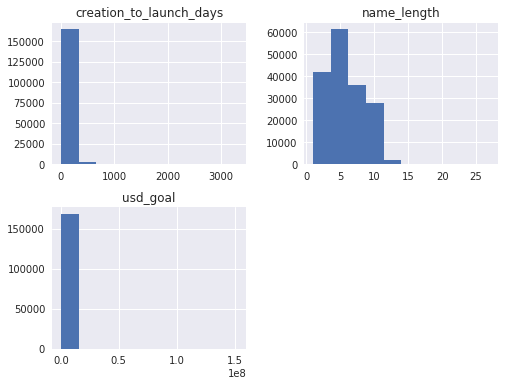

In [47]:
# Assessing skewed distributions
cols_to_log = ['creation_to_launch_days', 'name_length', 'usd_goal']
df_transformed[cols_to_log].hist(figsize=(8,6));

In [48]:
# Replacing 0s with 0.01 and log-transforming
for col in cols_to_log:
    df_transformed[col] = df_transformed[col].astype('float64').replace(0.0, 0.01)
    df_transformed[col] = np.log(df_transformed[col])

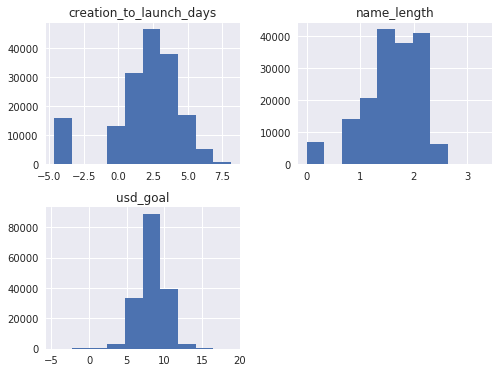

In [49]:
df_transformed[cols_to_log].hist(figsize=(8,6));

Now the data can be prepared again for machine learning by separating X and y, and scaling:

In [94]:
#X_unscaled_log = df_transformed.drop('state', axis=1)
#y_log = df_transformed.state
from sklearn.utils import shuffle
data_shuffle = shuffle(df_transformed)
data_reduced = data_shuffle.iloc[:50000,:]
X_unscaled_log = data_reduced.drop('state', axis=1)
y_log = data_reduced.state

In [95]:
# Transforming the data
scaler = StandardScaler()
X_log = pd.DataFrame(scaler.fit_transform(X_unscaled_log), columns=list(X_unscaled_log.columns))
X_log.head()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


blurb_length  usd_goal  name_length  creation_to_launch_days  \
0     -3.612796 -0.003591    -0.871861                 0.044167   
1      0.600265 -0.319683    -0.871861                -0.758570   
2     -1.205333  2.816268     0.012933                 0.286833   
3      0.399643 -0.470887     0.827020                 0.286833   
4      0.399643 -1.518089     1.031030                -2.536329   

   campaign_days  category_art  category_comics  category_crafts  \
0      -0.139165     -0.346514        -0.191346        -0.179813   
1      -0.649296     -0.346514        -0.191346         5.561338   
2      -0.224187     -0.346514        -0.191346        -0.179813   
3      -0.224187     -0.346514        -0.191346        -0.179813   
4      -0.224187     -0.346514        -0.191346        -0.179813   

   category_dance  category_design  category_fashion  category_film & video  \
0       -0.134851         -0.18715         -0.236949              -0.410518   
1       -0.134851         -0.18715         -0.236949              -0.410518   
2       -0.134851         -0.18715         -0.236949              -0.410518   
3       -0.134851         -0.18715         -0.236949              -0.410518   
4       -0.134851         -0.18715         -0.236949               2.435950   

   category_food  category_games  category_journalism  category_music  \
0      -0.294242        3.872323             -0.14646       -0.414766   
1      -0.294242       -0.258243             -0.14646       -0.414766   
2      -0.294242        3.872323             -0.14646       -0.414766   
3      -0.294242       -0.258243             -0.14646       -0.414766   
4      -0.294242       -0.258243             -0.14646       -0.414766   

   category_photography  category_publishing  category_technology  \
0             -0.184037            -0.333815            -0.344955   
1             -0.184037            -0.333815            -0.344955   
2             -0.184037            -0.333815            -0.344955   
3             -0.184037            -0.333815             2.898931   
4             -0.184037            -0.333815            -0.344955   

   category_theater  country_AT  country_AU  country_BE  country_CA  \
0         -0.168913   -0.048222   -0.149774   -0.052417   -0.220485   
1         -0.168913   -0.048222   -0.149774   -0.052417   -0.220485   
2         -0.168913   -0.048222   -0.149774   -0.052417   -0.220485   
3         -0.168913   -0.048222   -0.149774   -0.052417   -0.220485   
4         -0.168913   -0.048222   -0.149774   -0.052417   -0.220485   

   country_CH  ...  deadline_month_September  launch_time_10am-12pm  \
0   -0.052608  ...                 -0.297202              -0.208706   
1   -0.052608  ...                 -0.297202              -0.208706   
2   -0.052608  ...                 -0.297202              -0.208706   
3   -0.052608  ...                 -0.297202              -0.208706   
4   -0.052608  ...                  3.364720              -0.208706   

   launch_time_10pm-12am  launch_time_12am-2am  launch_time_12pm-2pm  \
0              -0.337724             -0.301209             -0.278293   
1              -0.337724             -0.301209             -0.278293   
2               2.961002             -0.301209             -0.278293   
3              -0.337724             -0.301209              3.593338   
4              -0.337724             -0.301209             -0.278293   

   launch_time_2am-4am  launch_time_2pm-4pm  launch_time_4am-6am  \
0            -0.261139             2.741877            -0.235628   
1            -0.261139            -0.364714            -0.235628   
2            -0.261139            -0.364714            -0.235628   
3            -0.261139            -0.364714            -0.235628   
4            -0.261139             2.741877            -0.235628   

   launch_time_4pm-6pm  launch_time_6am-8am  launch_time_6pm-8pm  \
0            -0.411016            -0.201613            -0.388263   
1             2.432994        

In [96]:
# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_log, y_log, test_size=0.3, random_state=123)

In [97]:
def plot_cf(y_true, y_pred, class_names=None, model_name=None):
    """Plots a confusion matrix"""
    cf = confusion_matrix(y_true, y_pred)
    plt.imshow(cf, cmap=plt.cm.Blues)
    plt.grid(b=None)
    if model_name:
        plt.title("Confusion Matrix: {}".format(model_name))
    else:
        plt.title("Confusion Matrix")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    class_names = set(y_true)
    tick_marks = np.arange(len(class_names))
    if class_names:
        plt.xticks(tick_marks, class_names)
        plt.yticks(tick_marks, class_names)
    
    thresh = cf.max() / 2.
    
    for i, j in itertools.product(range(cf.shape[0]), range(cf.shape[1])):
        plt.text(j, i, cf[i, j], horizontalalignment='center', color='white' if cf[i, j] > thresh else 'black')

    plt.colorbar()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Logistic regression score for training set: 0.73346
Logistic regression score for test set: 0.7308

Classification report:
              precision    recall  f1-score   support

           0       0.71      0.64      0.68      6549
           1       0.74      0.80      0.77      8451

   micro avg       0.73      0.73      0.73     15000
   macro avg       0.73      0.72      0.72     15000
weighted avg       0.73      0.73      0.73     15000



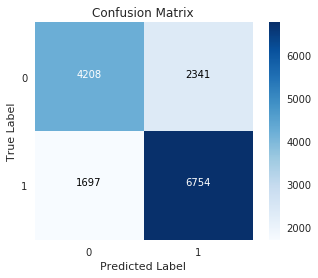

In [70]:
# Fitting a logistic regression model with default parameters
logreg = LogisticRegression()
logreg.fit(X_train,y_train)

# Making predictions
lr_y_hat_train = logreg.predict(X_train)
lr_y_hat_test = logreg.predict(X_test)

# Logistic regression scores
print("Logistic regression score for training set:", round(logreg.score(X_train, y_train),5))
print("Logistic regression score for test set:", round(logreg.score(X_test, y_test),5))
print("\nClassification report:")
print(classification_report(y_test, lr_y_hat_test))
# Confusion matrix
plot_cf(y_test, lr_y_hat_test)

# Grid Search

## Grid Search for Logistic Regression

In [71]:
# Using GridSearchCV to test multiple different parameters
logreg_start = time.time()

logreg = LogisticRegression()

params_logreg = [
    {'penalty': ['l1', 'l2'],
     'fit_intercept': [True, False],
        'C': [0.001, 0.01, 1, 10]
    }
]

grid_logreg = GridSearchCV(estimator=logreg,
                  param_grid=params_logreg,
                  cv=5)

grid_logreg.fit(X_train, y_train)

logreg_end = time.time()

logreg_best_score = grid_logreg.best_score_
logreg_best_params = grid_logreg.best_params_

print(f"Time taken to run: {round((logreg_end - logreg_start)/60,1)} minutes")
print("Best accuracy:", round(logreg_best_score,2))
print("Best parameters:", logreg_best_params)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework

Time taken to run: 1.5 minutes
Best accuracy: 0.73
Best parameters: {'C': 0.001, 'fit_intercept': True, 'penalty': 'l2'}


Results from the logistic Regression parameter optimisation:

- Time taken to run: 5.0 minutes
- Best accuracy: 0.73
- Best parameters: {'C': 0.01, 'fit_intercept': True, 'penalty': 'l1'}

## Grid Search for Random Forest

In [72]:
# Using GridSearchCV to test multiple different parameters
rf_start = time.time()

rf = RandomForestClassifier(min_samples_split=0.001, verbose=2)

params_rf = [ 
  {'n_estimators': [200, 400],
   'max_depth': [20, 35]
  }
]

grid_rf = GridSearchCV(estimator=rf, param_grid=params_rf, cv=5)

grid_rf.fit(X_train, y_train)

rf_end = time.time()

rf_best_score = grid_rf.best_score_
rf_best_params = grid_rf.best_params_

print(f"Time taken to run: {round((rf_end - rf_start)/60,1)} minutes")
print("Best accuracy:", round(rf_best_score,2))
print("Best parameters:", rf_best_params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
b

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    8.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
b

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    8.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
b

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    6.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
b

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    6.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
b

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    5.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 

building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   11.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 8 of 400
building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 o

building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   11.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 8 of 400
building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 o

building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   11.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 8 of 400
building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 o

building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   11.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
b

building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   12.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
b

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    9.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
b

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    8.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
b

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    6.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
b

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    6.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
b

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    6.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
b

building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   16.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
b

building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   14.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
b

building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   15.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    2.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
b

building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   15.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 

building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   16.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 

building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   18.2s finished


Results from the Random Forest parameter optimisation:

- Time taken to run: 16.8 minutes
- Best accuracy: 0.74
- Best parameters: {'max_depth': 35, 'n_estimators': 200}

## Grid Search for XGBoost

In [99]:
# Using GridSearchCV to test multiple different parameters
xgb_start = time.time()

xgb = xgb.XGBClassifier(learning_rate=0.1, max_depth=35, verbose=2)

params_xgb = [ 
  {'n_estimators': [200, 300],
   'subsample': [0.9, 1.0],
   'min_child_weight': [50, 100, 150]
  }
]

grid_xgb = GridSearchCV(estimator=xgb, param_grid=params_xgb, cv=5)

grid_xgb.fit(X_train, y_train)

xgb_end = time.time()

xgb_best_score = grid_xgb.best_score_
xgb_best_params = grid_xgb.best_params_

print(f"Time taken to run: {round((xgb_end - xgb_start)/60,1)} minutes")
print("Best accuracy:", round(xgb_best_score,2))
print("Best parameters:", xgb_best_params)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:542: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)


XGBoostError: b'value 1.1 for Parameter subsample exceed bound [0,1]'

Results from the XGBoost parameter optimisation:

- Time taken to run: 16.8 minutes
- Best accuracy: 0.74
- Best parameters: {'max_depth': 35, 'n_estimators': 200}

## Grid Search for KNN

In [82]:
# Using GridSearchCV to test multiple different parameters
knn_start = time.time()

knn = KNeighborsClassifier()

params_knn = [ 
  {'n_neighbors': list(range(2,10)),
   'weights': ['uniform', 'distance'],
   'algorithm': ['ball_tree']
  }
]

grid_knn = GridSearchCV(estimator=knn, param_grid=params_knn, cv=5)

grid_knn.fit(X_train, y_train)

knn_end = time.time()

knn_best_score = grid_knn.best_score_
knn_best_params = grid_knn.best_params_

print(f"Time taken to run: {round((knn_end - knn_start)/60,1)} minutes")
print("Best accuracy:", round(knn_best_score,2))
print("Best parameters:", knn_best_params)

Time taken to run: 6.3 minutes
Best accuracy: 0.61
Best parameters: {'algorithm': 'ball_tree', 'n_neighbors': 9, 'weights': 'uniform'}


Results from the KNN parameter optimisation:

- Time taken to run: 6.3 minutes
- Best accuracy: 0.61
- Best parameters: {'algorithm': 'ball_tree', 'n_neighbors': 9, 'weights': 'uniform'}

## Grid Search for AbaBoost

In [98]:
# Using GridSearchCV to test multiple different parameters
adaboost_start = time.time()

adaboost = AdaBoostClassifier()

params_adaboost = {
 'n_estimators': [100, 200, 300],
 'learning_rate': [0.01, 0.05, 0.1, 0.3, 1]
}

grid_adaboost = GridSearchCV(estimator=adaboost, param_grid=params_adaboost, cv=5)

grid_adaboost.fit(X_train, y_train)

adaboost_end = time.time()

adaboost_best_score = grid_adaboost.best_score_
adaboost_best_params = grid_adaboost.best_params_

print(f"Time taken to run: {round((adaboost_end - adaboost_start)/60,1)} minutes")
print("Best accuracy:", round(adaboost_best_score,2))
print("Best parameters:", adaboost_best_params)

Time taken to run: 6.8 minutes
Best accuracy: 0.74
Best parameters: {'learning_rate': 0.3, 'n_estimators': 300}


Results from the AdaBoost parameter optimisation:

- Time taken to run: 6.8 minutes
- Best accuracy: 0.74
- Best parameters: {'learning_rate': 0.3, 'n_estimators': 300}